In [1]:
%run femshape/femshape
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, sin, pi
from numpy.linalg import norm

## Create some planar curves

(-0.99, 0.99, -0.7699999999999999, 0.7699999999999999)

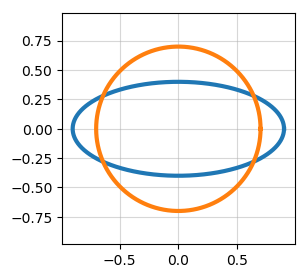

In [2]:
n = 20000
t = np.linspace(0,2*pi,n,endpoint=False)
gamma1_highres = np.vstack((0.9*cos(t),0.4*sin(t))).T

n = 1000
t = np.linspace(0,2*pi,n,endpoint=False)
gamma1_lowres = np.vstack((0.9*cos(t),0.4*sin(t))).T

n = 5000
t = np.linspace(0,2*np.pi,n,endpoint=False)
gamma1 = np.vstack((0.9*cos(t),0.4*sin(t))).T

gamma1_repar1 = np.roll(gamma1,n//4,axis=0)
gamma1_repar2 = np.vstack((0.9*cos(t+pi/2),0.4*sin(t+pi/2))).T
gamma1_repar3 = np.vstack((0.9*cos(t+0.01*sin(3*t)),0.4*sin(t+0.01*sin(3*t)))).T

reg_pert = np.vstack((cos(6*t),sin(7*t))).T
rand_pert = np.random.randn(n,2)

gamma2 = np.vstack((0.7*cos(t),0.7*sin(t))).T

for gamma in [gamma1, gamma2]:
    plt.plot(gamma[:,0],gamma[:,1], lw=3)
plt.grid(alpha=.5)
plt.axis('equal')

## Create the space

In [3]:
space = Space(order=2, meshsize=64)

## Compute the invariants

In [4]:
%%time
curves = [gamma1, gamma2, gamma1_repar1, gamma1_repar2, gamma1_repar3, gamma1_highres, gamma1_lowres]
currents = [Current(space, curve) for curve in curves]

CPU times: user 1.53 s, sys: 20.5 ms, total: 1.55 s
Wall time: 1.58 s


For visualisation, we also compute representers.

In [5]:
%%time
reps = [Representer(current, scale=1/10) for current in currents]

CPU times: user 3.45 s, sys: 354 ms, total: 3.8 s
Wall time: 2.03 s


## Compute relative errors of perturbations

General utility function to compare relative difference of invariants.

In [6]:
def rel_inv_diff(current, inv):
    return norm(inv - current.invariants)/norm(inv)

### Check approximate invariance under reparameterization

In [7]:
inv1 = currents[0].invariants

In [8]:
template = "Relative norm between invariants for gamma1 and {} is {:.4e}"
for name, current in zip(['gamma2', 'gamma1_repar1', 'gamma1_repar2', 'gamma1_repar3', 'gamma1_highres', 'gamma1_lowres'], currents[1:]):
    print(template.format(name, rel_inv_diff(current, inv1)))

Relative norm between invariants for gamma1 and gamma2 is 1.4200e+00
Relative norm between invariants for gamma1 and gamma1_repar1 is 1.0663e-17
Relative norm between invariants for gamma1 and gamma1_repar2 is 1.4263e-15
Relative norm between invariants for gamma1 and gamma1_repar3 is 6.9777e-04
Relative norm between invariants for gamma1 and gamma1_highres is 5.2060e-04
Relative norm between invariants for gamma1 and gamma1_lowres is 1.2557e-02


### Check sensitivity w.r.t. perturbations

Copute currents and their invariants for two kinds of perturbations.

In [9]:
%%time
epsvec = np.logspace(-8,-1,10)

reg_pert_currents,rand_pert_currents = [[Current(space, gamma1+epsilon*pert) 
                                         for epsilon in epsvec] for pert in [reg_pert, rand_pert]]

errvec_reg, errvec_rand = [[rel_inv_diff(current, inv1) for current in current_list] 
                           for current_list in [reg_pert_currents, rand_pert_currents]]

CPU times: user 3.66 s, sys: 43.7 ms, total: 3.7 s
Wall time: 3.78 s


For visualisation, we also compute the representers.

In [10]:
%%time
reg_reps, rand_reps = [[Representer(current, scale=1/10) for current in current_list] 
                       for current_list in [reg_pert_currents, rand_pert_currents]]

CPU times: user 10.9 s, sys: 1.74 s, total: 12.7 s
Wall time: 8.54 s


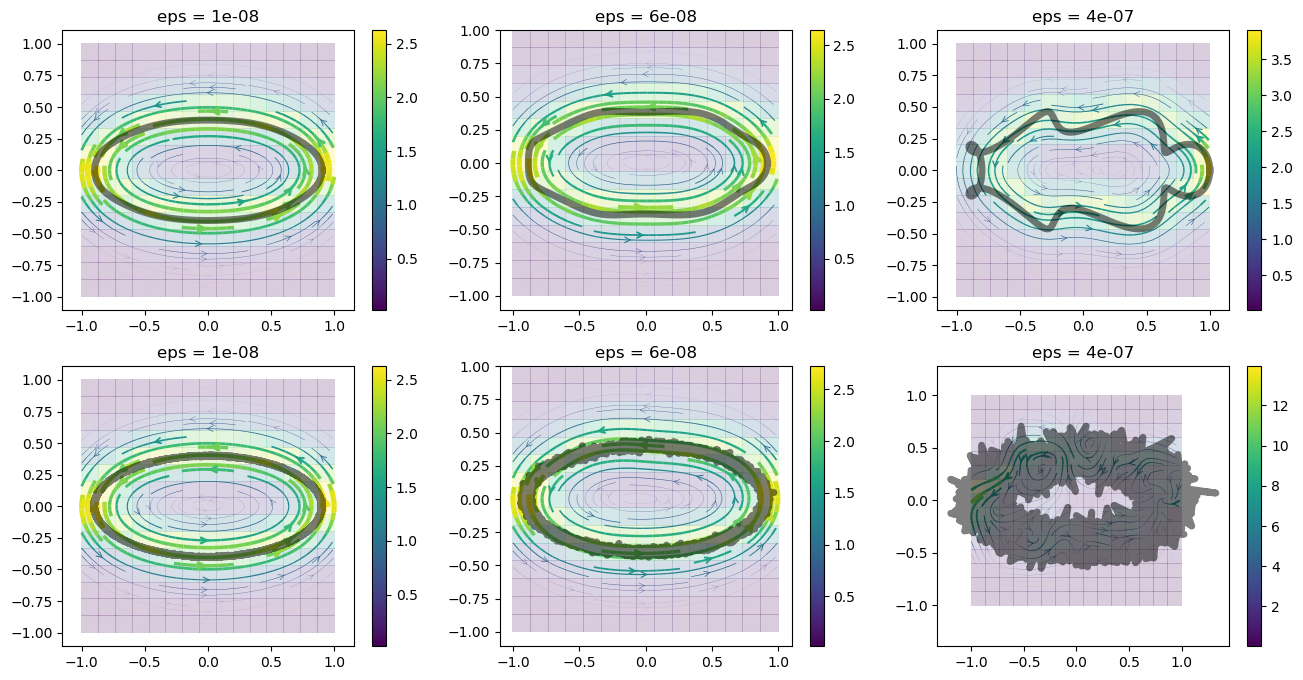

In [11]:
plt.figure(figsize=(16,8))
M = 3
for i,reps in enumerate([reg_reps, rand_reps]):
    for j, (rep, eps) in enumerate(zip(reps[-M:], epsvec)):
        plt.subplot(2,M,M*i + j +1)
        plt.title("eps = {:.0e}".format(eps))
        plot_representer(rep, size=16)

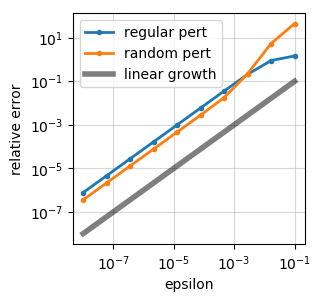

In [12]:
for s,d in [('regular pert', errvec_reg),
           ('random pert', errvec_rand),]:
    plt.loglog(epsvec, d, '.-', lw=2, label=s)
plt.loglog(epsvec, epsvec, alpha=.5, color='k', lw=4, label='linear growth')
plt.xlabel('epsilon')
plt.ylabel('relative error')
plt.grid(alpha=.5)
plt.legend()

### Relative errors for other function spaces

In [13]:
shapecalc_loword = Space(order=1, meshsize=64)
shapecalc_highord = Space(order=8, meshsize=64)
shapecalc_fine = Space(order=2, meshsize=256)
shapecalc_rough = Space(order=8, meshsize=8)

In [14]:
calc = shapecalc_rough
inv11 = Current(calc, gamma1).invariants

epsvec2 = np.logspace(-8,-1,10)

reg_pert_currents2 = [Current(calc, gamma1+epsilon*reg_pert) for epsilon in epsvec2]
errvec2_reg = [rel_inv_diff(current, inv11) for current in reg_pert_currents2]
                                        


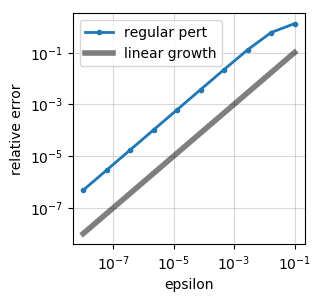

In [15]:
plt.loglog(epsvec2, errvec2_reg, '.-', lw=2, label='regular pert')
plt.loglog(epsvec2, epsvec2, lw=4, color='k', alpha=.5, label='linear growth')
plt.xlabel('epsilon')
plt.ylabel('relative error')
plt.grid(alpha=.5)
plt.legend()

In [16]:
calc.V.dim()

4225

## Visualize the invariants through FEniCS functions

In [17]:
calc = shapecalc_loword
cur = Current(calc, gamma1)
(xx, yy, xmat,ymat) = cur.space.grid_evaluation(cur.invariant_dx, cur.invariant_dy, size=64)

(-1.1, 1.1, -1.1, 1.1)

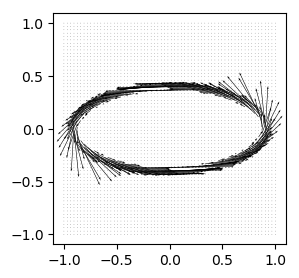

In [18]:
plt.quiver(xx, yy, xmat, ymat)
plt.axis('equal')

(-1.0142857142857142,
 -0.7000000000000001,
 -0.3317460317460318,
 0.33174603174603157)

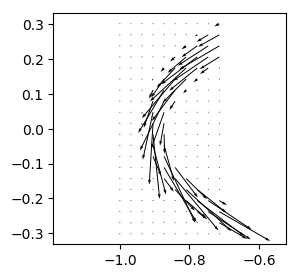

In [19]:
zoomy = slice(0,10)
zoomx = slice(32-10,32+10)
plt.quiver(xx[zoomx, zoomy], yy[zoomx, zoomy], xmat[zoomx, zoomy], ymat[zoomx, zoomy])
plt.axis('equal')